# Compare synthetic forecasts from model fit to real GCM forecasts

To do:
- Check what your forecasts look like relative to real forecasts
- Try fitting to hindcast winter NAO index
- Trend in one signal and trend in both signals

In [1]:
import cftime

import itertools

import numpy as np

import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

import dask

dask.config.set(**{"array.slicing.split_large_chunks": False})

from src import utils, plot, stats, ar_model

In [2]:
DATA_DIR = "../../data/processed/"

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

## Cluster

In [203]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
Client(cluster)

<Client: 'tcp://10.6.53.30:39167' processes=0 threads=0, memory=0 B>

## Load some data to fit and compare to

#### Reanalysis data

In [93]:
tos = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(tos["sst"], [12, 1, 2, 3]).to_dataset(name="AMV")
AMV = utils.round_to_start_of_month(AMV, dim="time")

psl = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(psl["slp"], [12, 1, 2, 3]).to_dataset(name="NAO")

reanalysis = xr.merge((AMV.compute(), NAO.compute()), join="inner")

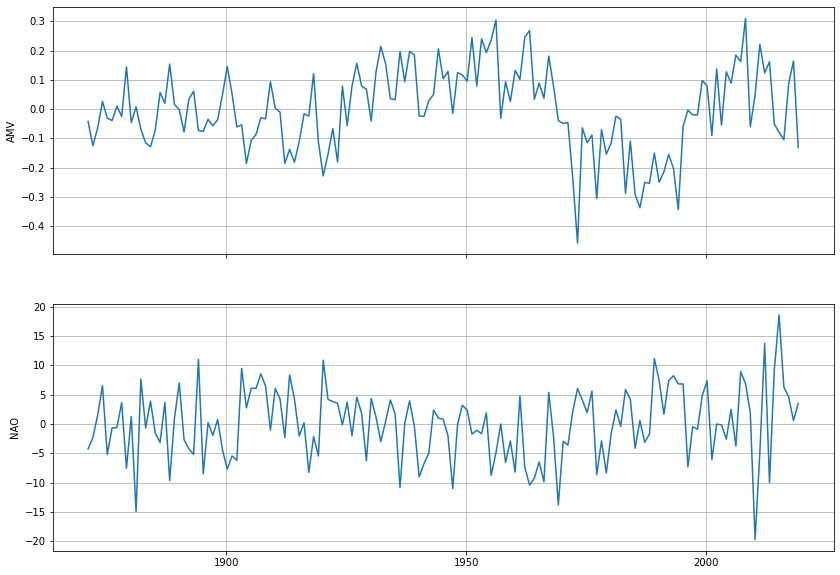

In [94]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(len(reanalysis), 1, sharex=True)

for idx, var in enumerate(reanalysis):
    ax = axs[idx]
    ax.plot(reanalysis.time, reanalysis[var])
    ax.set_ylabel(var)

#### Multi-model CMIP6 historical data

In [95]:
models = ["HadGEM3-GC31-MM"]

historical = []
prev_member = 0
for model in models:
    tos = xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True)
    AMV = utils.calculate_period_AMV_index(tos["tos"], [12, 1, 2, 3]).to_dataset(
        name="AMV"
    )

    psl = (
        xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_historical.zarr", use_cftime=True)
        / 100
    )
    NAO = utils.calculate_period_NAO_index(psl["psl"], [12, 1, 2, 3]).to_dataset(
        name="NAO"
    )

    ds = xr.merge((AMV.compute(), NAO.compute()))
    ds = ds.assign_coords({"member": ds.member + prev_member})
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})

    prev_member = ds.member.values[-1]

    historical.append(ds)

historical = xr.concat(historical, dim="member")

# historical = utils.detrend(historical)

In [96]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(len(historical), 1, sharex=True)


def lighten(color, amount=0.3):
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


_, counts = np.unique(historical.model, return_counts=True)
colors = list(itertools.chain(*[n * [f"C{i}"] for i, n in enumerate(counts)]))
colors = [lighten(color) for color in colors]

for idx, var in enumerate(historical):
    ax = axs[idx]
    ax.set_prop_cycle("color", colors)
    ax.plot(historical.time, historical[var].T)
    ax.set_ylabel(var)

#### Multi-model CMIP6 dcpp data

In [204]:
models = ["HadGEM3-GC31-MM", "EC-Earth3", "MIROC6", "NorCPM1"]

max_init = "2018"

hindcast = []
prev_member = 0
for model in models:
    tos = xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True)
    AMV = utils.calculate_period_AMV_index(
        tos["tos"].sel(init=slice(max_init)), [12, 1, 2, 3]
    ).to_dataset(name="AMV")

    psl = xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_dcpp.zarr", use_cftime=True) / 100
    NAO = utils.calculate_period_NAO_index(
        psl["psl"].sel(init=slice(max_init)), [12, 1, 2, 3]
    ).to_dataset(name="NAO")

    ds = xr.merge((AMV.compute(), NAO.compute()))
    ds = ds.sel(lead=slice(14, 120)).assign_coords({"lead": range(1, 10)})
    ds = ds.assign_coords({"member": ds.member + prev_member})
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})
    ds = ds.assign_coords({"init": range(1960, 1960 + ds.sizes["init"])})
    ds = utils.round_to_start_of_month(ds, "time")

    prev_member = ds.member.values[-1]

    hindcast.append(ds)

hindcast = xr.concat(hindcast, dim="member", coords="minimal", compat="override")

hindcast_mean = utils.get_hindcast_mean(
    hindcast, mean_lead_range=[(0, 1), (0, 4), (0, 8)]
)

# hindcast = utils.detrend(hindcast)

## Fit a VAR model and generate some samples to compare to real hindcasts

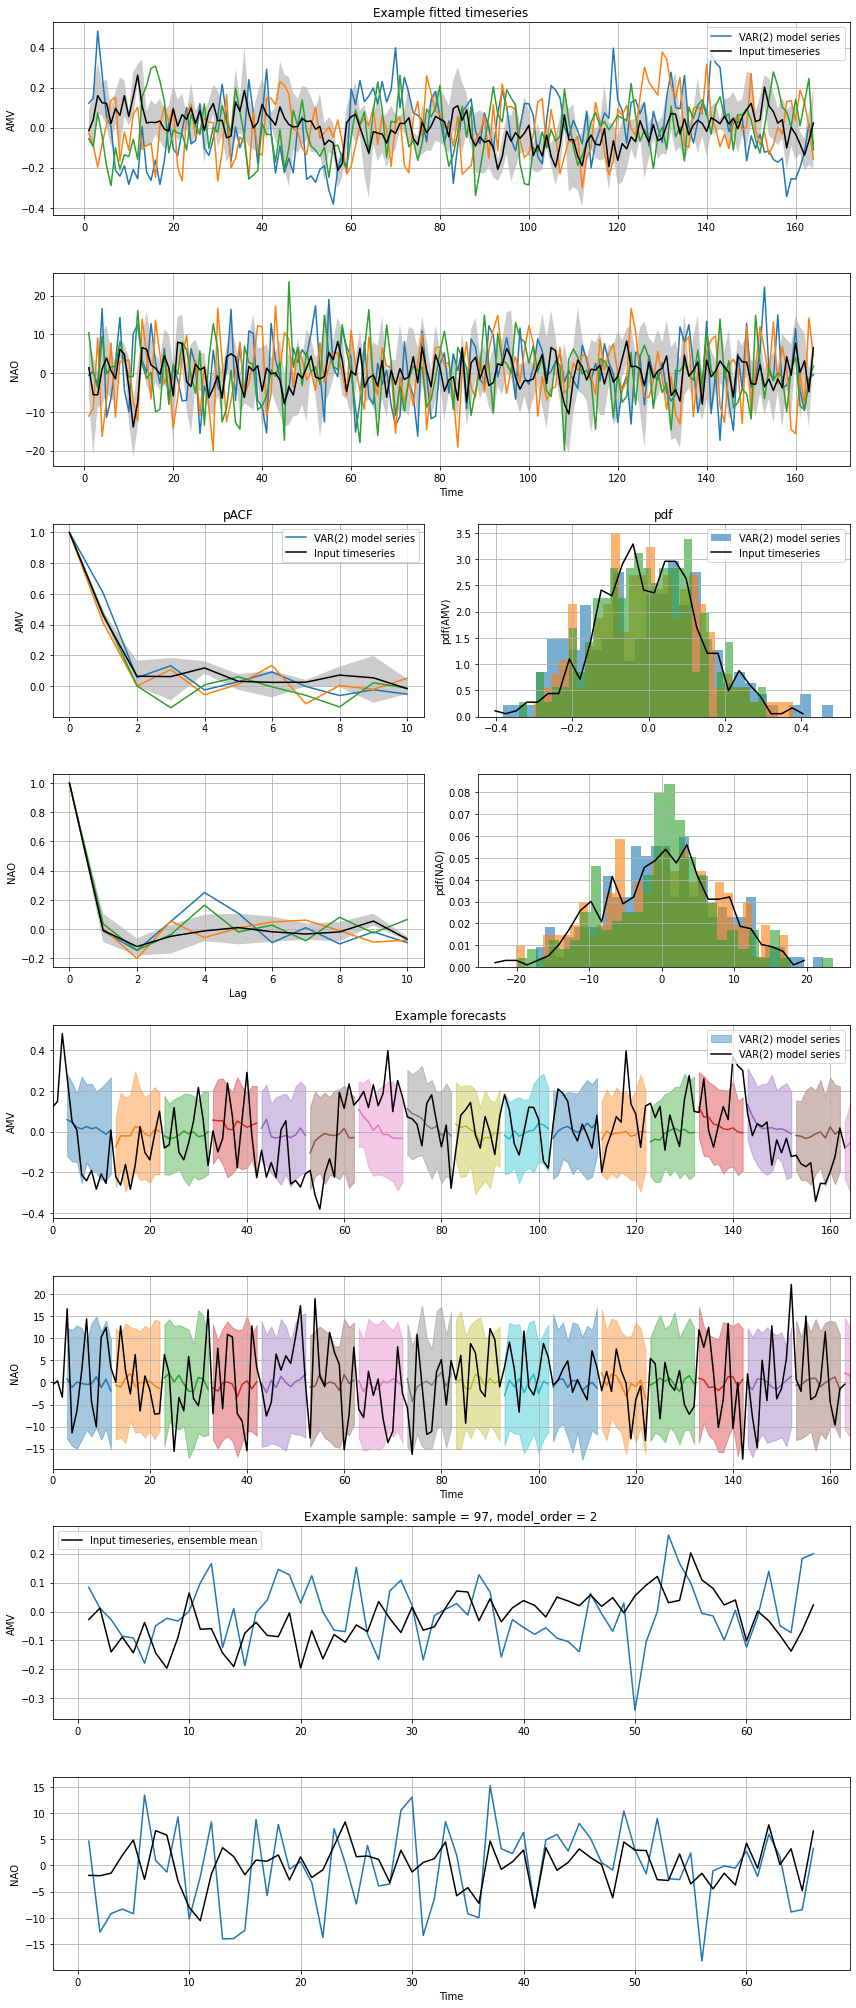

In [195]:
synthetic = ar_model.generate_samples_like(
    historical,
    n_lags=2,
    n_times=hindcast_mean.sizes["time"],
    n_samples=100,
    n_members=None,  # hindcast_mean.sizes["member"],
    rolling_means=None,  # [4, 8],
)

## Compare the synthetic data to the real hindcasts

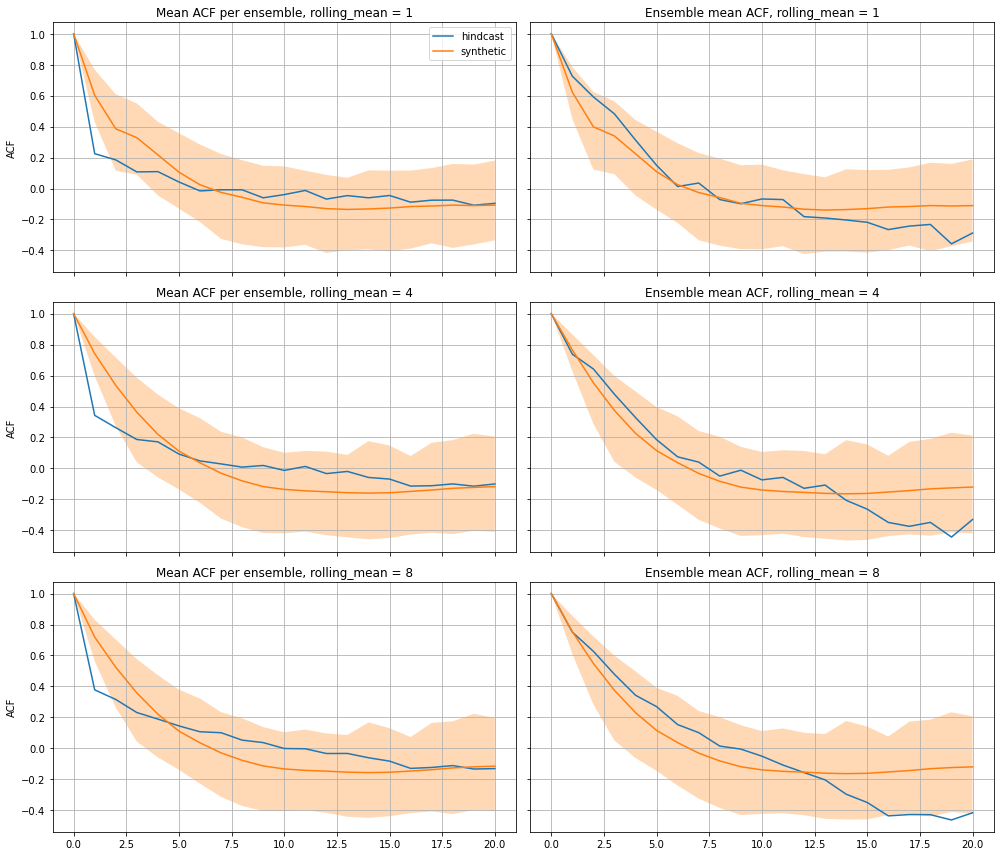

In [179]:
plot.acf(
    utils.detrend(hindcast_mean["AMV"]),
    utils.detrend(synthetic["AMV"]),
    headings=["hindcast", "synthetic"],
    partial=False,
)

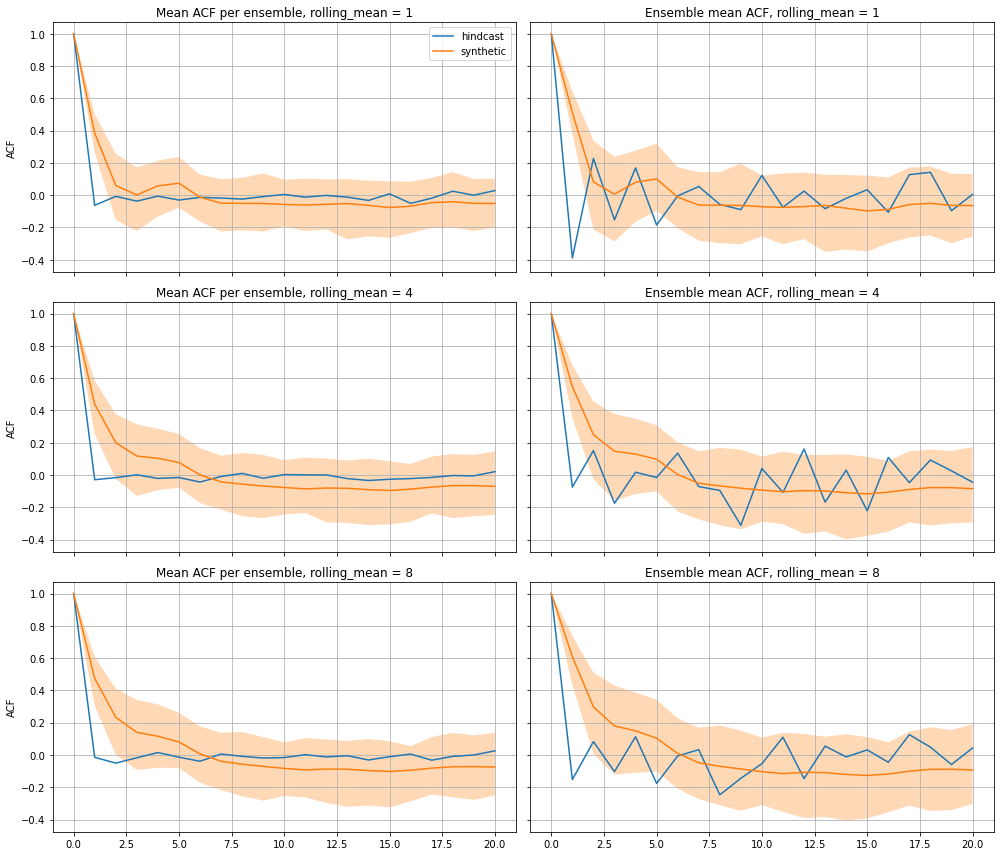

In [180]:
plot.acf(
    utils.detrend(hindcast_mean["NAO"]),
    utils.detrend(synthetic["NAO"]),
    headings=["hindcast", "synthetic"],
    partial=False,
)

#### Start your synthetic forecasts from real initial conditions and compare to real hindcasts

In [205]:
params = ar_model.fit(historical, n_lags=2).mean("member")

In [231]:
prediction = ar_model.predict(
    params, reanalysis, n_steps=9, n_members=hindcast.sizes["member"]
)
prediction = prediction.assign_coords({"init": prediction.init.dt.year})

(1960.0, 2027.0)

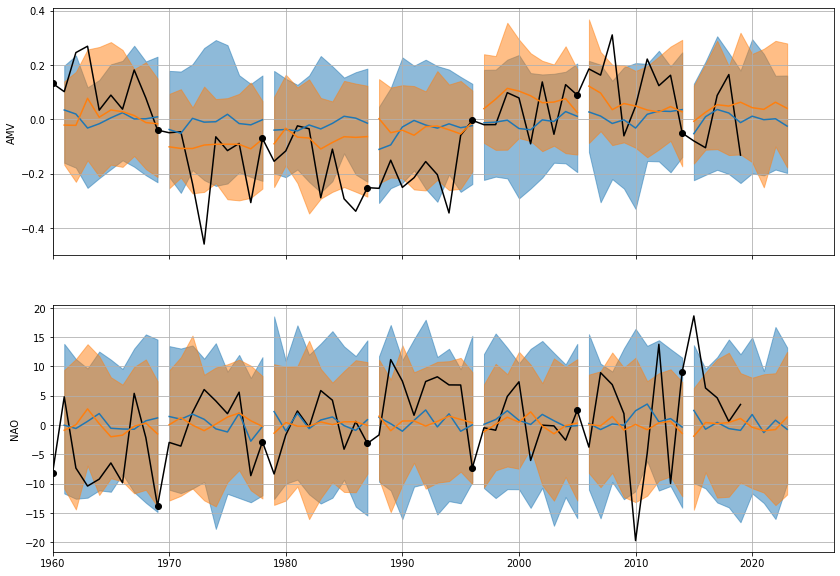

In [238]:
q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(len(hindcast), 1, sharex=True)

reanalysis_plot = reanalysis.assign_coords({"time": reanalysis.time.dt.year})
for idx, var in enumerate(hindcast):
    ax = axs[idx]
    ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
    for init in hindcast.init.values[::9]:
        ax.plot(
            init,
            reanalysis_plot[var].sel(time=init),
            marker="o",
            markersize=6,
            color="k",
        )

        prediction_plot = prediction[var].sel(init=init)
        ax.fill_between(
            prediction_plot.lead + init,
            prediction_plot.quantile(q[0], "member"),
            prediction_plot.quantile(q[1], "member"),
            alpha=0.5,
            color="C0",
        )
        ax.plot(prediction_plot.lead + init, prediction_plot.mean("member"), color="C0")

        hindcast_plot = hindcast[var].sel(init=init)
        ax.fill_between(
            hindcast_plot.lead + init,
            hindcast_plot.quantile(q[0], "member"),
            hindcast_plot.quantile(q[1], "member"),
            alpha=0.5,
            color="C1",
        )
        ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C1")

        ax.set_ylabel(var)

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [207]:
hindcast

<xarray.Dataset>
Dimensions:  (lead: 9, init: 59, member: 40)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017 2018
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
    time     (init, lead) object 1962-03-01 00:00:00 ... 2028-03-01 00:00:00
    model    (member) <U15 'HadGEM3-GC31-MM' 'HadGEM3-GC31-MM' ... 'NorCPM1'
Data variables:
    AMV      (init, member, lead) float64 -0.07769 0.1471 ... -0.02808 0.008354
    NAO      (init, member, lead) float64 -7.003 -14.47 -6.708 ... 6.069 2.563

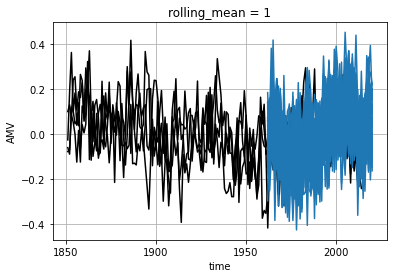

In [129]:
_ = historical["AMV"].plot.line(x="time", add_legend=False, color="k")
_ = hindcast.sel(rolling_mean=1)["AMV"].plot.line(
    x="time", color="C0", add_legend=False
)

## Boreal winter (December to March) NAO indices

In [ ]:
models = [

In [5]:
HadGEM3 = (
    xr.open_zarr(f"{DATA_DIR}/psl_Amon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True)
    / 100
)
NAO_HadGEM3 = utils.calculate_period_NAO_index(
    HadGEM3["psl"],
    [12, 1, 2, 3],
).compute()
NAO_HadGEM3 = NAO_HadGEM3.isel(lead=slice(1, None))  # Drop first lead

In [6]:
ECEarth3 = (
    xr.open_zarr(f"{DATA_DIR}/psl_Amon_EC-Earth3_dcpp.zarr", use_cftime=True) / 100
)
NAO_ECEarth3 = utils.calculate_period_NAO_index(
    ECEarth3["psl"],
    [12, 1, 2, 3],
).compute()
NAO_ECEarth3 = NAO_ECEarth3.isel(lead=slice(1, None))  # Drop first lead

In [7]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO_HadSLP = utils.calculate_period_NAO_index(
    HadSLP["slp"],
    [12, 1, 2, 3],
).compute()

### Fit an AR model

In [195]:
input_data = NAO_HadSLP

res = ar_model.fit(
    input_data,
    order="select_order",
)
params = res[:-1].values
scale = res[-1].values

### Generate some synthetic forecasts

In [ ]:
inits = ar_model.generate_samples(
    params=params,
    scale=scale,
    n_times=NAO_HadGEM3.sizes["init"],
    n_samples=1,
)

In [10]:
NAO_synthetic = ar_model.predict(
    params=params,
    inits=inits,
    n_steps=NAO_HadGEM3.sizes["lead"],
    n_members=NAO_HadGEM3.sizes["member"],
    scale=scale,
)

NAO_synthetic = NAO_synthetic.assign_coords(
    {"time": NAO_synthetic.init + NAO_synthetic.lead}
)

### How do the synthetic forecasts compare to the real forecasts?

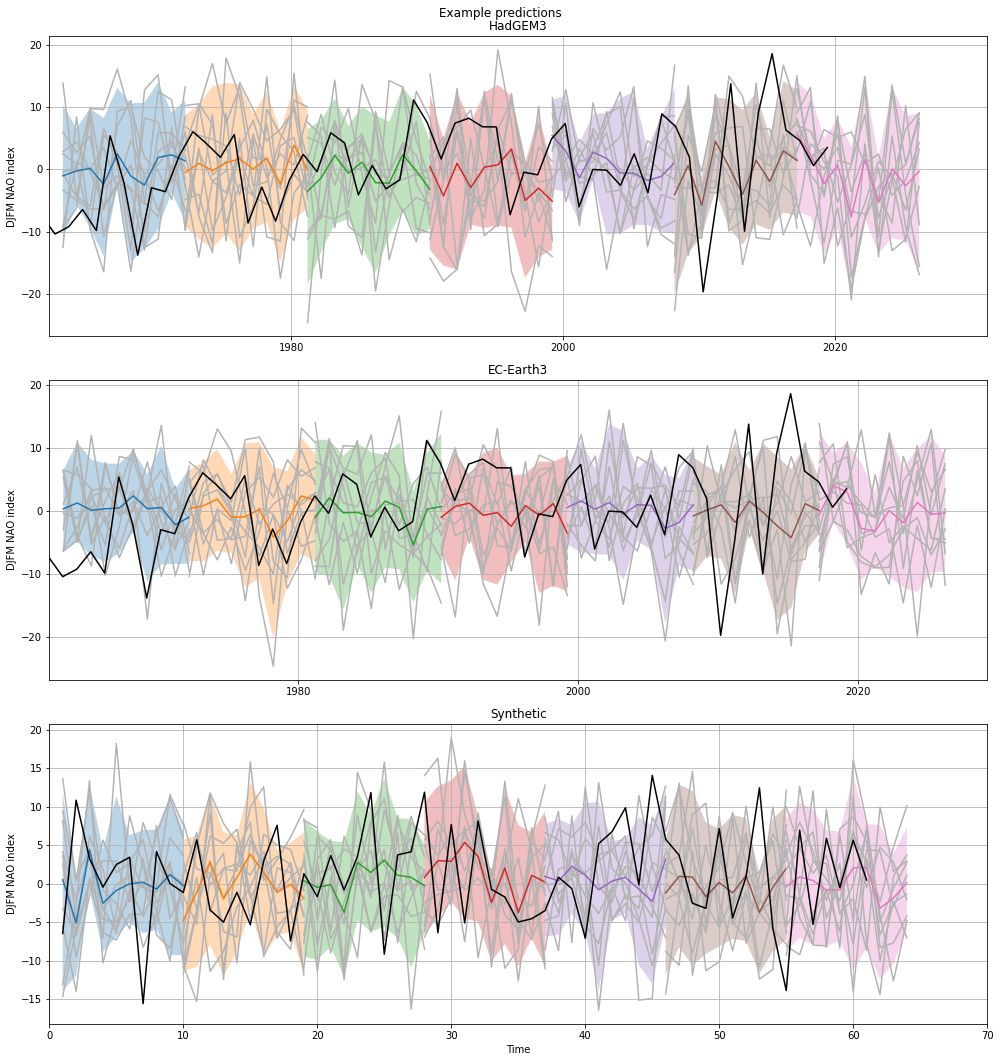

In [11]:
to_plot = {
    "HadGEM3": (NAO_HadGEM3, NAO_HadSLP),
    "EC-Earth3": (NAO_ECEarth3, NAO_HadSLP),
    "Synthetic": (NAO_synthetic, inits),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, (fcst, init)) in enumerate(to_plot.items()):
    ax = axs[i]

    for i in fcst.init[1::9]:
        fcst_plot = fcst.sel(init=i)
        ax.fill_between(
            fcst_plot.time.values,
            fcst_plot.quantile(0.05, dim="member"),
            fcst_plot.quantile(0.95, dim="member"),
            edgecolor="none",
            alpha=0.3,
        )
        for m in fcst_plot.member:
            ax.plot(
                fcst_plot.time.values, fcst_plot.sel(member=m), color=[0.7, 0.7, 0.7]
            )
        ax.plot(
            fcst_plot.time.values,
            fcst_plot.mean("member"),
        )
        ax.set_title(name)
    ax.set_xlim(fcst.time.min().item(), fcst.time.max().item())
    ax.set_ylabel("DJFM NAO index")

    ax.plot(init.time, init, color="k")

ax.set_xlabel("Time")
fig.suptitle("Example predictions")
fig.tight_layout()

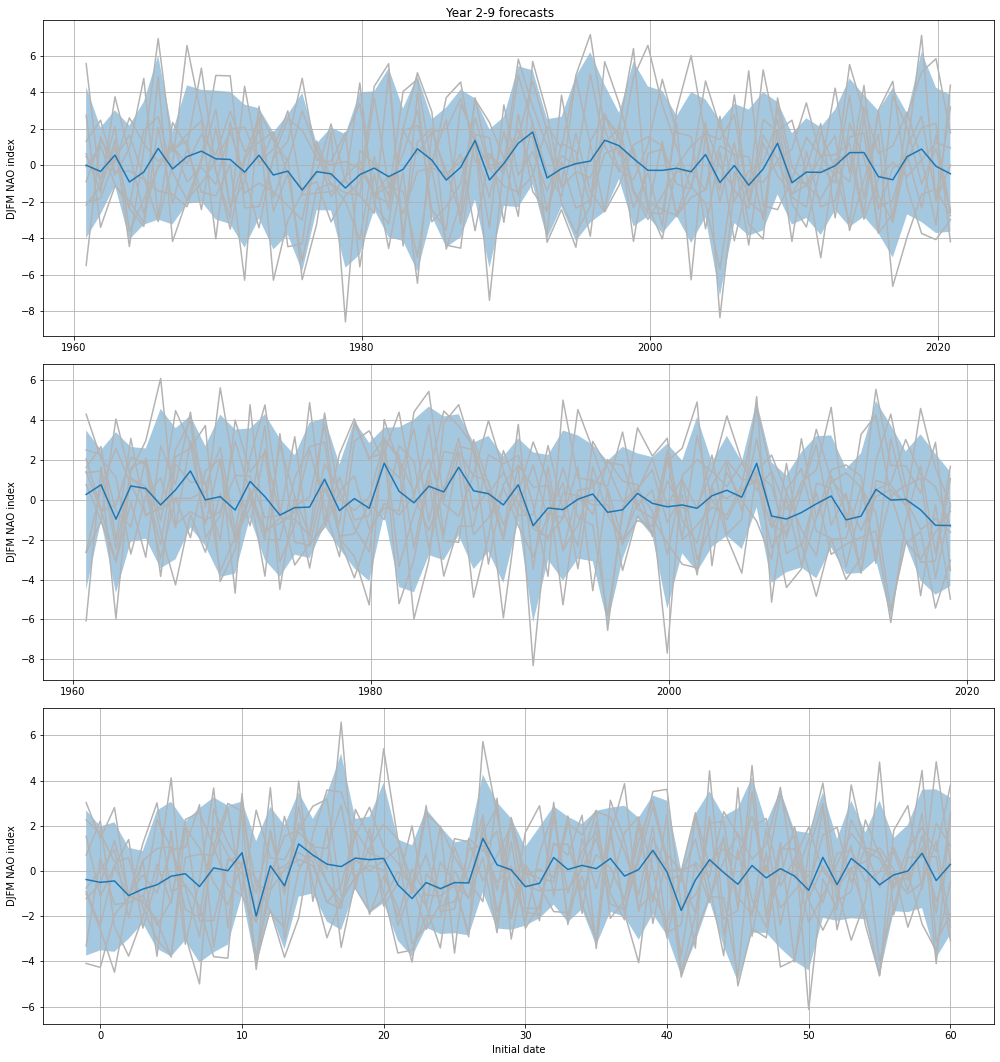

In [12]:
avg = (0, 8)

to_plot = {
    "HadGEM3": NAO_HadGEM3.isel(lead=slice(*avg)).mean("lead"),
    "EC-Earth3": NAO_ECEarth3.isel(lead=slice(*avg)).mean("lead"),
    "Synthetic": NAO_synthetic.isel(lead=slice(*avg)).mean("lead"),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, fcst) in enumerate(to_plot.items()):
    ax = axs[i]

    ax.fill_between(
        fcst.init.values,
        fcst.quantile(0.05, dim="member"),
        fcst.quantile(0.95, dim="member"),
        edgecolor="none",
        alpha=0.4,
    )
    for m in fcst.member:
        ax.plot(fcst.init.values, fcst.sel(member=m), color=[0.7, 0.7, 0.7])
    ax.plot(
        fcst.init.values,
        fcst.mean("member"),
    )
    ax.set_title("")  # name)
    ax.set_ylabel("DJFM NAO index")

ax.set_xlabel("Initial date")
fig.suptitle("Year 2-9 forecasts")
fig.tight_layout()

## Boreal winter (December to March) AMV indices

In [13]:
HadGEM3["tos"] = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True
)["tos"]
AMV_HadGEM3 = utils.calculate_period_AMV_index(
    HadGEM3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_HadGEM3 = AMV_HadGEM3.isel(lead=slice(1, None))  # Drop first lead

In [14]:
ECEarth3["tos"] = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_EC-Earth3_dcpp.zarr", use_cftime=True
)["tos"]
AMV_ECEarth3 = utils.calculate_period_AMV_index(
    ECEarth3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_ECEarth3 = AMV_ECEarth3.isel(lead=slice(1, None))  # Drop first lead

In [15]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV_HadISST = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).compute()

### Fit an AR model

In [16]:
input_data = AMV_HadISST

res = ar_model.fit(
    input_data,
    order="select_order",
    select_order_kwargs={"maxlag": 10, "ic": "aic", "glob": False, "trend": "n"},
)
params = res[:-1].values
scale = res[-1].values

### Generate some synthetic forecasts

In [22]:
inits = ar_model.generate_samples(
    params=params,
    scale=scale,
    n_times=AMV_HadGEM3.sizes["init"],
    n_samples=1,
)

In [23]:
AMV_synthetic = ar_model.predict(
    params=params,
    inits=inits,
    n_steps=AMV_HadGEM3.sizes["lead"],
    n_members=AMV_HadGEM3.sizes["member"],
    scale=scale,
)

AMV_synthetic = AMV_synthetic.assign_coords(
    {"time": AMV_synthetic.init + AMV_synthetic.lead}
)

### How do the synthetic forecasts compare to the real forecasts?

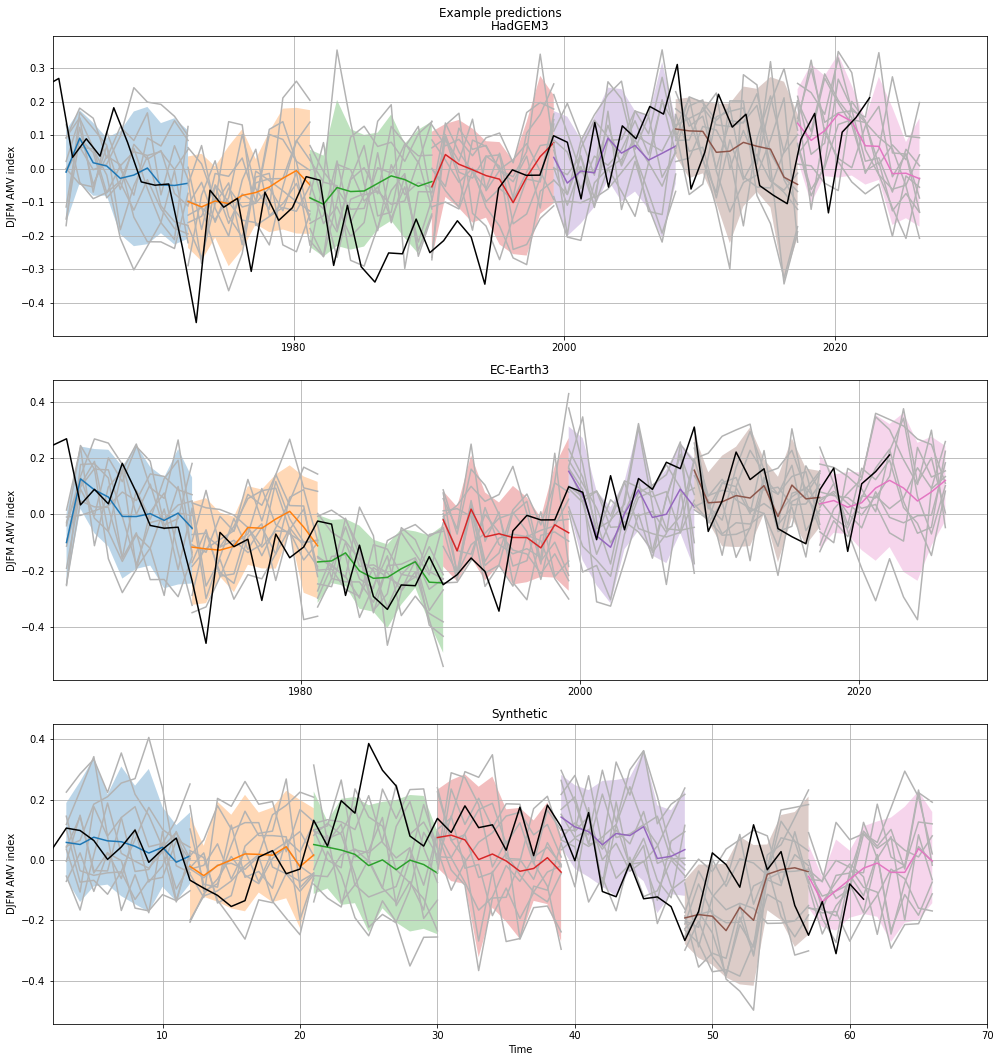

In [24]:
to_plot = {
    "HadGEM3": (AMV_HadGEM3, AMV_HadISST),
    "EC-Earth3": (AMV_ECEarth3, AMV_HadISST),
    "Synthetic": (AMV_synthetic, inits),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, (fcst, init)) in enumerate(to_plot.items()):
    ax = axs[i]

    for i in fcst.init[1::9]:
        fcst_plot = fcst.sel(init=i)
        ax.fill_between(
            fcst_plot.time.values,
            fcst_plot.quantile(0.05, dim="member"),
            fcst_plot.quantile(0.95, dim="member"),
            edgecolor="none",
            alpha=0.3,
        )
        for m in fcst_plot.member:
            ax.plot(
                fcst_plot.time.values, fcst_plot.sel(member=m), color=[0.7, 0.7, 0.7]
            )
        ax.plot(
            fcst_plot.time.values,
            fcst_plot.mean("member"),
        )
        ax.set_title(name)
    ax.set_xlim(fcst.time.min().item(), fcst.time.max().item())
    ax.set_ylabel("DJFM AMV index")

    ax.plot(init.time, init, color="k")

ax.set_xlabel("Time")
fig.suptitle("Example predictions")
fig.tight_layout()

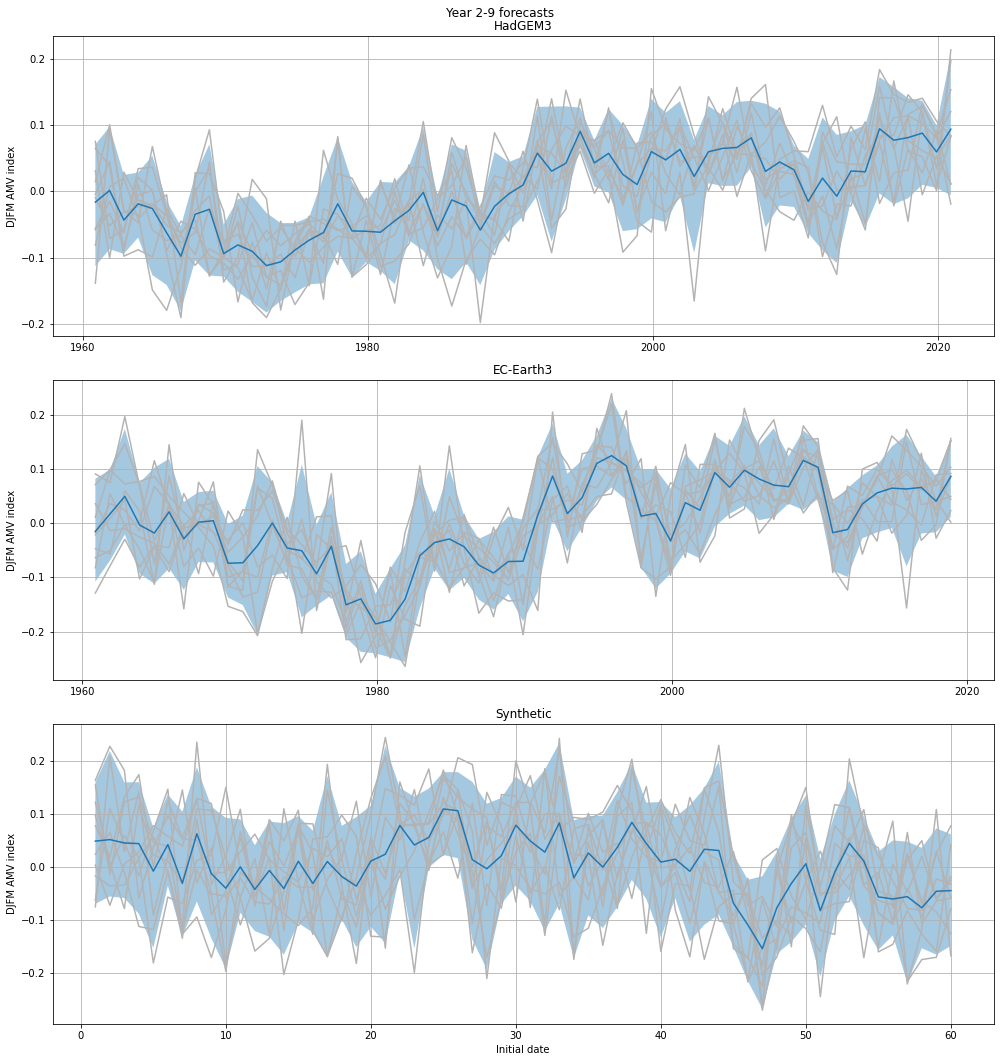

In [25]:
avg = (0, 8)

to_plot = {
    "HadGEM3": AMV_HadGEM3.isel(lead=slice(*avg)).mean("lead"),
    "EC-Earth3": AMV_ECEarth3.isel(lead=slice(*avg)).mean("lead"),
    "Synthetic": AMV_synthetic.isel(lead=slice(*avg)).mean("lead"),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, fcst) in enumerate(to_plot.items()):
    ax = axs[i]

    ax.fill_between(
        fcst.init.values,
        fcst.quantile(0.05, dim="member"),
        fcst.quantile(0.95, dim="member"),
        edgecolor="none",
        alpha=0.4,
    )
    for m in fcst.member:
        ax.plot(fcst.init.values, fcst.sel(member=m), color=[0.7, 0.7, 0.7])
    ax.plot(
        fcst.init.values,
        fcst.mean("member"),
    )
    ax.set_title(name)
    ax.set_ylabel("DJFM AMV index")

ax.set_xlabel("Initial date")
fig.suptitle("Year 2-9 forecasts")
fig.tight_layout()